## Семинар 5: "Улучшение сходимости нейросетей"

**ФИО**: Тимонина Дарья

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw




Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

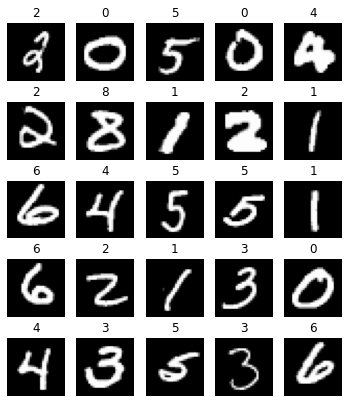

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [ ]:
def init_layer(layer, mean, std, init_func):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    if init_func == xavier:
        weight.uniform_(-std, std)
    else:    
        weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    

In [ ]:
layers = []

def normal(size_input, size_output):
    return 0.1

def counting(init_func):
    layers = []
    layer = nn.Linear(784, 500)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(784, 500), init_func) # сюда надо подставить другие параметры

    layers.append(layer)

    layers.append(nn.Tanh())

    for i in range(10):    
        layer = nn.Linear(500, 500)
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        init_layer(layer, 0.0, init_func(500, 500), init_func) # сюда надо подставить другие параметры
    
        layers.append(layer)
        layers.append(nn.Tanh())

    layer = nn.Linear(500, 10)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, init_func(500, 10), init_func)

    layers.append(layer)

    layers.append(nn.LogSoftmax())

    network = nn.Sequential(*layers)
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [ ]:
counting(normal)

forward 0.9991745948791504
forward 0.8509283661842346
forward 0.7867933511734009
forward 0.7693830728530884
forward 0.7682247757911682
forward 0.764503538608551
forward 0.7646785974502563
forward 0.7611390948295593
forward 0.7623628973960876
forward 0.7657545804977417
forward 0.7639102935791016
forward 0.764579713344574
backward 0.04063250124454498
backward 0.0065049477852880955
backward 0.00790323968976736
backward 0.009363737888634205
backward 0.01060514710843563
backward 0.012497159652411938
backward 0.015539380721747875
backward 0.020523637533187866
backward 0.02428998425602913
backward 0.0273135919123888
backward 0.03174363076686859
backward 0.03170566260814667


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [ ]:
##### YOUR CODE HERE #####

def xavier(size_input, size_output):
    d = 6. / (size_input + size_output)
    return np.sqrt(d)

def he(size_input, size_output):
    d = 2. / size_output
    return np.sqrt(d)

In [ ]:
counting(xavier)

forward 0.9991745948791504
forward 0.647831380367279
forward 0.5004415512084961
forward 0.41499456763267517
forward 0.3619958758354187
forward 0.32170626521110535
forward 0.29076337814331055
forward 0.270599365234375
forward 0.254257470369339
forward 0.24200715124607086
forward 0.22416456043720245
forward 0.21273024380207062
backward 0.017708633095026016
backward 0.0032375510782003403
backward 0.002918004058301449
backward 0.0026556444354355335
backward 0.0025196310598403215
backward 0.0024317672941833735
backward 0.002308584749698639
backward 0.002329791197553277
backward 0.002309444360435009
backward 0.0021569475065916777
backward 0.0018916288390755653
backward 0.001568506588228047


In [ ]:
counting(he)

forward 0.9991745948791504
forward 0.7668440341949463
forward 0.6505753397941589
forward 0.5981225967407227
forward 0.5811432003974915
forward 0.5738949179649353
forward 0.5665675401687622
forward 0.5583720803260803
forward 0.5548287630081177
forward 0.5575849413871765
forward 0.557065486907959
forward 0.5549479722976685
backward 0.05091574788093567
backward 0.05340928956866264
backward 0.054392725229263306
backward 0.06141059100627899
backward 0.06627172231674194
backward 0.06702776998281479
backward 0.07150239497423172
backward 0.06982108950614929
backward 0.06837109476327896
backward 0.06712857633829117
backward 0.06415512412786484
backward 0.047204408794641495


<i> 1.4 Сделайте выводы по первой части </i>

Вроде бы He и Xavier работают адекватнее

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [5]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [6]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [7]:
sizes = [196, 256, 128, 10]
layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    layer = nn.Linear(size_input, size_output)
    layer = DropConnect(size_input, size_output, 0.9)
    
    layers.append(layer)
    #layers.append(nn.Dropout(0.3))
    layers.append(nn.ReLU())

del layers[-1]

Epoch 9... (Train/Test) NLL: 0.121/0.265	Accuracy: 0.963/0.977


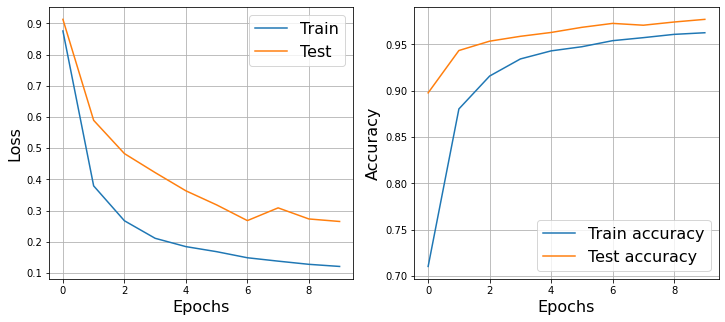

CPU times: user 2min 22s, sys: 1.9 s, total: 2min 24s
Wall time: 2min 30s


In [11]:
%%time

#blank
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.438/0.061	Accuracy: 0.783/0.982


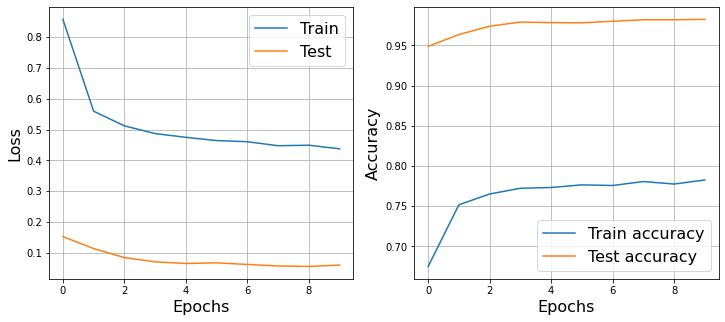

CPU times: user 1min 51s, sys: 439 ms, total: 1min 51s
Wall time: 1min 51s


In [ ]:
%%time

#dropout
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.154/0.332	Accuracy: 0.952/0.969


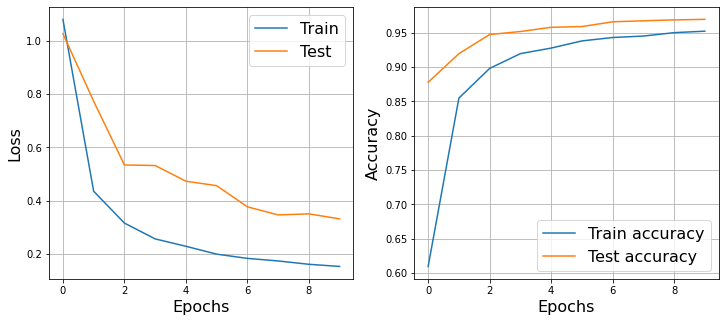

CPU times: user 1min 54s, sys: 413 ms, total: 1min 54s
Wall time: 1min 54s


In [ ]:
%%time

#dropconnect
from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [13]:
from train_utils import train

In [43]:
x = torch.tensor(np.array([[1., 2., 3.], [4., 5., 6]]))
mean = x.mean(1, keepdim=True)
std = x.std(1, keepdim=True)
print(mean)
print(std)
print((x - mean) / std)

tensor([[2.],
        [5.]], dtype=torch.float64)
tensor([[1.],
        [1.]], dtype=torch.float64)
tensor([[-1.,  0.,  1.],
        [-1.,  0.,  1.]], dtype=torch.float64)


In [38]:
# полезные функции: .std(dim), .mean(dim)
class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return (x - mean) / std

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.035/0.051	Accuracy: 0.992/0.986


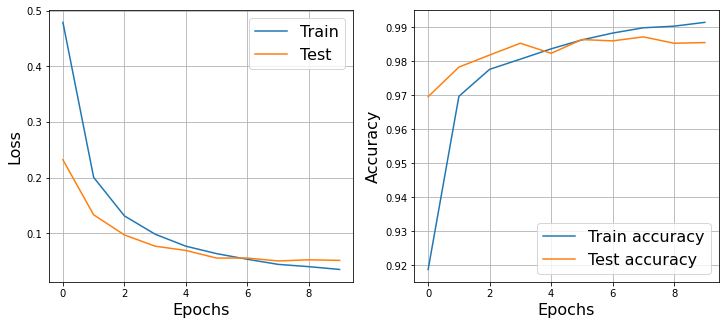

([0.4792857023952866,
  0.20039850462283662,
  0.13108860594091384,
  0.0981425803655119,
  0.07655897068141747,
  0.06317389282241051,
  0.05303604888525217,
  0.04386240978842414,
  0.03974200455324927,
  0.034735967190678056],
 [0.23198056013523777,
  0.13302126479677007,
  0.09684068318220633,
  0.07659623498403573,
  0.06886580815137941,
  0.05521830855102479,
  0.05521923040711804,
  0.050035514668384684,
  0.052057838928001594,
  0.05104994140801173],
 [0.9188211,
  0.96974945,
  0.9776952,
  0.9806825,
  0.9837198,
  0.98634064,
  0.98835623,
  0.9899109,
  0.99038845,
  0.99151003],
 [0.96964,
  0.9783426,
  0.9819027,
  0.9853639,
  0.98239714,
  0.98645175,
  0.98605615,
  0.9872429,
  0.9853639,
  0.9855617])

In [42]:
##### YOUR CODE HERE #####
lin_network = nn.Sequential(
                        nn.BatchNorm1d(num_features=196),
                        nn.Linear(196, 128), 
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=128),
                        nn.Linear(128, 128),
                        nn.ReLU(),
                        nn.BatchNorm1d(num_features=128),
                        nn.Linear(128, 10),
                        nn.BatchNorm1d(num_features=10),
                        nn.LogSoftmax())
network = TestNetwork(lin_network)

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

Epoch 9... (Train/Test) NLL: 0.355/0.373	Accuracy: 0.988/0.980


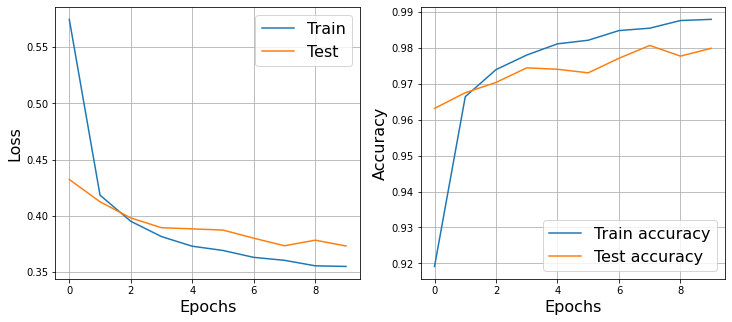

([0.574554702874694,
  0.41841581336724987,
  0.39522696354750125,
  0.38161869108804,
  0.3730885273993397,
  0.36929866411030166,
  0.36317794339489073,
  0.36056057571856454,
  0.3556794556600453,
  0.35511751412582804],
 [0.4323371037652221,
  0.4125641146792641,
  0.3981791878048378,
  0.38951901997191996,
  0.38848081985606425,
  0.3874274582802495,
  0.38021008500569986,
  0.3734905787661106,
  0.37844779182084,
  0.3732854022255427],
 [0.91915977,
  0.9663624,
  0.97389174,
  0.97795063,
  0.98106563,
  0.9820651,
  0.9847526,
  0.9854189,
  0.9875455,
  0.98787314],
 [0.9631131,
  0.9674644,
  0.97033226,
  0.9743869,
  0.9739913,
  0.9730024,
  0.977057,
  0.9806171,
  0.97765034,
  0.979826])

In [39]:
lin_network = nn.Sequential(
                        LayerNormalization(),
                        nn.Linear(196, 128), 
                        nn.ReLU(),
                        LayerNormalization(),
                        nn.Linear(128, 128),
                        nn.ReLU(),
                        LayerNormalization(),
                        nn.Linear(128, 10),
                        LayerNormalization(),
                        nn.LogSoftmax())
network = TestNetwork(lin_network)

train(network, train_loader, test_loader, 10, 0.001, device='cuda')

<i> 3.3 Сделайте выводы по третьей части </i>

Обе показали неплохой результат, лучше себя показала nn.BatchNorm1d


#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: